## Apply kernelized regression to Image

This notebook continues kernel notebook. We will condense up until $\alpha$ calculation.

In [1]:
import ee
import numpy as np
from ee_ipl_uv import kernel

ee.Initialize()

numpixels = 100
# Get some bands of an image
im_original = ee.Image('LANDSAT/LC8_L1T_TOA/LC81980332015119LGN00')
properties = ["B4","B3","B2"]
im = im_original.select(properties)

# Sample 100 pixels of this 3 band image using seed 45. Resulting object is a featureCollection
feature_collection = im.sample(numPixels=numpixels,seed=45)
kernel_rbf = kernel.Kernel(feature_collection,properties,distancia = kernel.RBFDistance(.5))

# Select B5 band
im_layer_5 = im_original.select("B5")
B5_vector = im_layer_5.sample(numPixels=numpixels,seed=45)
B5_vector = ee.Array(B5_vector.aggregate_array("B5"))
B5_vector = ee.Array.cat([B5_vector], 1) #Convert B5 to 2D array!

np_alpha_vector = kernel_rbf.getAlphaNumpy(B5_vector,.1)
print("Shape of alpha vector:",np_alpha_vector.shape)
print("Norm of alpha vector:",np.linalg.norm(np_alpha_vector))


('Shape of alpha vector:', (100, 1))
('Norm of alpha vector:', 5.3050682017048354)


(100, 1)

We are trying to predict band `B5` using bands `B4`, `B3` and `B2`. Using our 100 pixels kernel.

In [2]:
from IPython.display import Image
Image(url=im_original.getThumbUrl({
    'bands':'B4,B3,B2',
    'min':0,
    'max':0.3
}))

In [3]:
Image(url=im_layer_5.getThumbUrl())

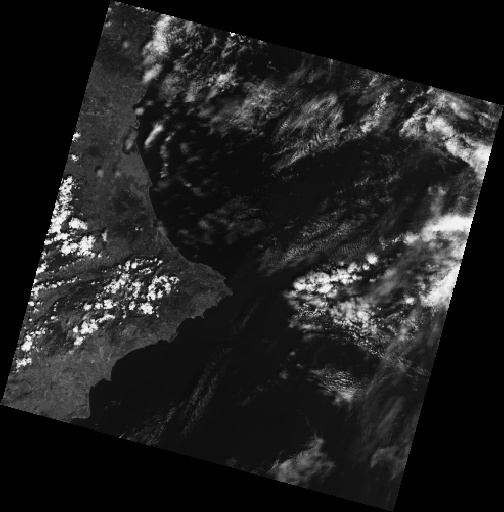

In [5]:
from ee_ipl_uv import download

image_applied = ee.Image(kernel_rbf.applyModelToImage(im_original,np_alpha_vector))

image_local = download.MaybeDownloadThumb(image_applied.arrayGet([0,0]),
                                          image_name="regresion.jpg",
                                         force=True)
Image(image_local)


## Checkout computations

To checkout the application to the model has been correctly implemented we will download a clipped image with all its layers (`B[2-5]` and the `B5_regressed`). We will apply the model locally using `numpy` and then we will compare the results.